<a href="https://colab.research.google.com/github/DavideScassola/PML2024/blob/main/./Notebooks/05_HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 5: Hidden Markov Models (HMM)

This notebook is inspired from [this Medium page.](https://medium.com/@natsunoyuki/hidden-markov-models-with-python-c026f778dfa7)

Hidden Markov Models (HMMs) are probabilistic models used to model discrete sequential data where the underlying system is assumed to be a Markov process with unobservable (hidden) states. 

![hmm](imgs/hmm.png)

Key components and concepts of HMMs:

1. Markov Process (Markov Chain):
A Markov process is a stochastic model where the probability of transitioning to the next state depends only on the current state and not on the sequence of events that preceded it.
In a Markov chain, each state has a certain probability distribution of transitioning to other states.

2. Hidden States:
In an HMM, we have a sequence of hidden states ${Z_t}$ that we cannot directly observe. These states are assumed to form a Markov chain, meaning the probability of moving to the next state depends only on the current state.
Hidden states represent the underlying structure or phenomenon that generates the observed data.

3. Observations: Associated with each hidden state, there is an observable outcome ${X_t}$ at each time step t.
Observations are generated from the hidden states according to certain probability distributions specific to each state.

4. Model Parameters: HMMs are characterized by three sets of parameters:
    - Initial State Distribution ($\pi$):probability distribution over the initial hidden states, i.e. $p(z_1)$.
    - State Transition Probability Matrix (A): matrix representing the probabilities of transitioning between hidden states, s.t. $A_{ij} = p(z_n = j | z_{n-1} = i)$
    - Emission Probability, parametrized by $\psi$: probability of observing each possible outcome  given the hidden state, i.e. $p(x_n | z_n)$.

5. Inference: 
    - Filtering: compute $p(z_N | \underline{x})$ where $z_N$ is the last latent variable
    - Smoothing: compute $p(z_n | \underline{x})$ with n < N
    - Most likely explanation: determine the most likely sequence of hidden states that generated a given sequence of observations
    - Likelihood computation: evaluate the likelihood of a given sequence of observations under the HMM model

As a first example, we perform exact inference using the sum-product algorithm that we implemented in the previous notebook (see the example on the notebook 04_exact_inference.ipynb)

## Example: Gold price analysis

As an application example, we analyse historical gold prices using the `hmmlearn` library.

In [34]:
# !pip install hmmlearn

First, we import the necessary libraries as well as the data into python. In general dealing with the change in price rather than the actual price itself leads to better modeling of the actual market conditions, so we calculate the daily change in gold price.

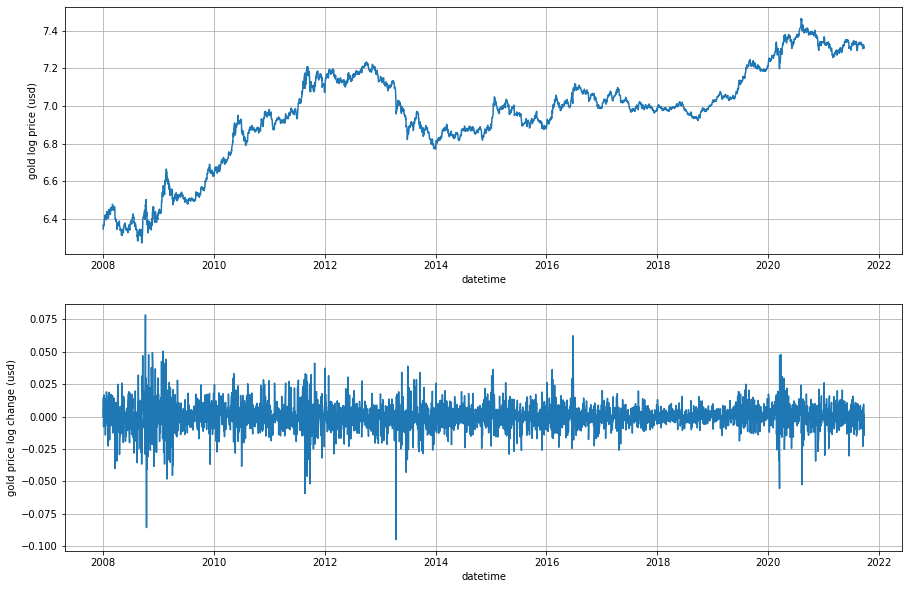

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

DATA_URL = "https://github.com/natsunoyuki/Data_Science/blob/master/gold/gold/gold_price_usd.csv?raw=True"
FROM = "2008-01-01"

data = pd.read_csv(DATA_URL)
data['datetime'] = pd.to_datetime(data["datetime"])
data.index = data['datetime']

# Log-transform the gold prices. Why? 
data["gold_log_price_usd"] = np.log(data["gold_price_usd"])

# Determine the daily change in gold price.
data["gold_log_price_change"] = data["gold_log_price_usd"].diff()

# Use only data from 2008.
data = data[FROM:]

# Plot the daily gold prices as well as the daily change.
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.plot(data["gold_log_price_usd"])
plt.xlabel("datetime")
plt.ylabel("gold log price (usd)")
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(data["gold_log_price_change"])
plt.xlabel("datetime")
plt.ylabel("gold price log change (usd)")
plt.grid(True)
plt.show()

Instead of modeling the gold price directly, we model the daily change in the gold price — this allows us to better capture the state of the market. We fit the daily change in gold prices to a Gaussian emissions model with two possible hidden states ($z_i \in \{0, 1\}$).
`hmmlearn` will fit the emission distribution $p(x_i | z_i)$ and the transition distribution $p(z_{i} | z_{i-1})$ by maximum likelihood.

In [36]:
# We use the daily change in gold price as the observed measurements X.

# We normalize the log price, so the model can learn better.
data["x"] = (data["gold_log_price_change"] - np.mean(data["gold_log_price_change"])) / np.std(data["gold_log_price_change"])

X = data[["x"]].to_numpy() # Build the HMM model and fit to the gold log price change data.
model = hmm.GaussianHMM(n_components = 2, covariance_type = "diag", n_iter = 100, random_state = 2)

# Fitting the model: The transition matrix and emission probabilities are learned by maximum likelihood.
model.fit(X)

GaussianHMM(n_components=2, n_iter=100, random_state=2)

We can now see the learned transition matrix and emission distribution:


Gaussian distribution means:
[[ 0.00648568]
 [-0.00171571]]

Gaussian distribution covariances:
[[[3.04821067]]

 [[0.45816323]]]

Start probabilities:
[0. 1.]

Transition matrix:
[[0.89 0.11]
 [0.03 0.97]]


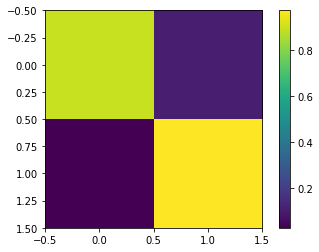

In [37]:
print("\nGaussian distribution means:")
print(model.means_)

print("\nGaussian distribution covariances:")
print(model.covars_)

print("\nStart probabilities:")
print(np.round(model.startprob_, 2))

print("\nTransition matrix:")
print(np.round(model.transmat_,2))

_ = plt.imshow(model.transmat_)
_ = plt.colorbar()

Given this learned model, we `hmmlearn` allows to infer the posterior distribution of every hidden state $p(z_i)$ (by belief propagation) and also to find the most probable sequence of hidden states (by Viterbi algorithm):

In [38]:
Z = model.predict(X) # Find most probable hidden states sequence
Z_prob = model.predict_proba(X)  # Find posterior for each hidden state

Plotting the model’s state predictions with the data, we find that the states 0, 1 and 2 appear to correspond to low volatility, medium volatility and high volatility.

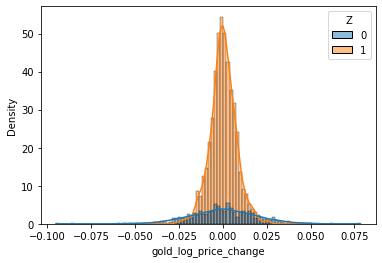

In [39]:
import seaborn as sns
data['Z'] = Z
_ = sns.histplot(data=data, x='gold_log_price_change', hue='Z', bins=100, kde=True, stat = "density")

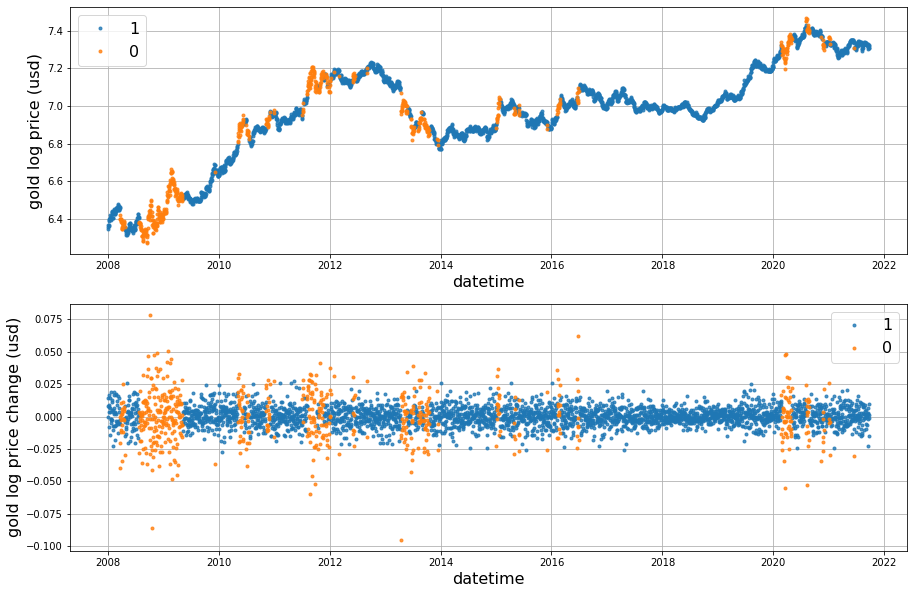

In [40]:
plt.figure(figsize = (15, 10))

STATES = np.unique(Z)[::-1]

plt.subplot(2,1,1)
for i in STATES:
    want = (Z == i)
    x = data["datetime"][want]
    y = data["gold_log_price_usd"][want]
    plt.plot(x, y, '.', alpha = 0.8)
plt.legend(STATES, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold log price (usd)", fontsize=16)

plt.subplot(2,1,2)
for i in STATES:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_log_price_change"].iloc[want]
    plt.plot(x, y, '.', alpha = 0.8)
plt.legend(STATES, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold log price change (usd)", fontsize=16)
plt.show()

The model did a sort of clustering, creating two groups, one for high volatility and one for low volatility

We can also plot the posterior probability instead of the most probable sequence:

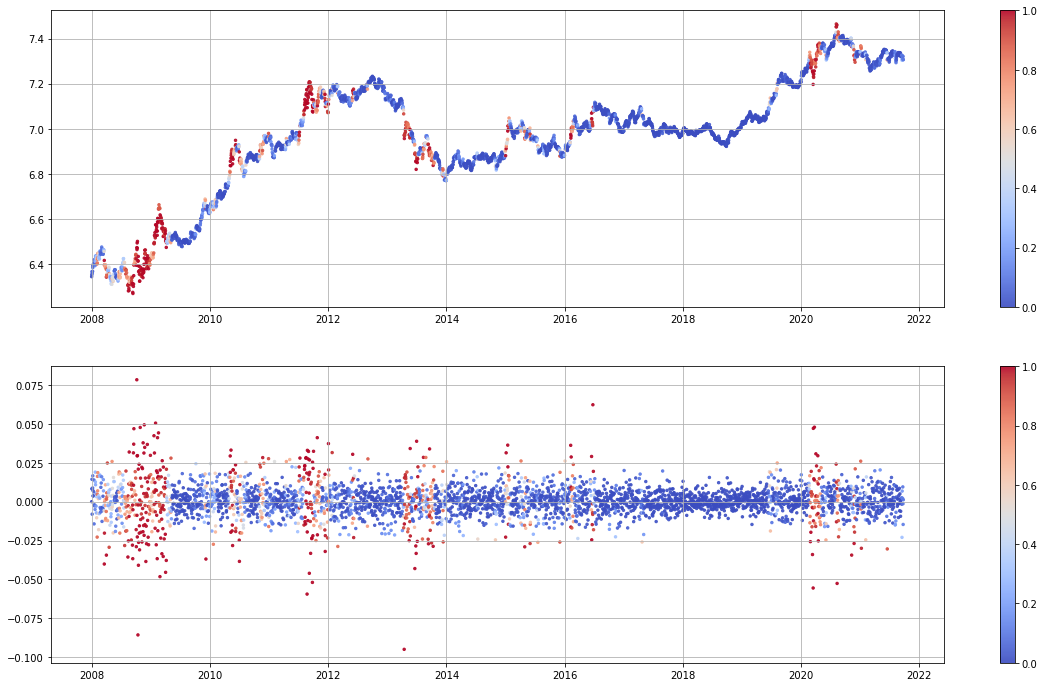

In [41]:
plt.figure(figsize = (20, 12))
plt.subplot(2,1,1)
plt.scatter(data.index, data["gold_log_price_usd"], c = Z_prob[:,0], alpha=0.9, cmap = "coolwarm", s = 6)
plt.grid(True)
plt.colorbar()

plt.subplot(2,1,2)
plt.scatter(data.index, data["gold_log_price_change"], c = Z_prob[:,0], alpha=0.9, cmap = "coolwarm", s = 6)
plt.grid(True)
_ = plt.colorbar()

## Exercises

1.1 Given the gold price data, fit a HMM with a different number of hidden states

1.2 Why the sequence of $z_i$ that maximizes the posteriors $p(z_i)$ is not equal to the most probable sequence $z_i$ found with the Viterbi algorithm?

2.1 Load the dataset from https://raw.githubusercontent.com/DavideScassola/PML2024/main/data/weather_prediction_dataset.csv

2.2 Build an HMM modelling the weather, with a multivariate Gaussian as emission distribution.  Then show the learned transition matrix and emission probabilities.

2.3 Plot The data showing the inferred hidden states

2.4 Simulate 2 years of data using the fitted model

2.5 Simulate data for the next week (next in the sense that follows from the last observation of the dataset)